## Imports

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import math
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn. metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline

### Read data into DFs

In [39]:
# 1. Column names (15 features + label)
headers = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'pred'   # label (<=50K / >50K)
]

# 2. Read raw data
original_train_df = pd.read_csv(
    "census-income.data.csv",
    header=None,
    names=headers,
    index_col=False
)

original_test_df = pd.read_csv(
    "census-income.test.csv",
    header=None,
    names=headers,
    index_col=False
)

# Work on copies
train_df = original_train_df.copy()
test_df = original_test_df.copy()

train_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,pred
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [40]:
test_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,pred
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [41]:
#strip whitespace

def data_to_str(df):
    """
    Strip leading/trailing spaces from all string (object) columns.
    """
    str_cols = df.select_dtypes(include=['object']).columns
    for col in str_cols:
        df[col] = df[col].str.strip()
    return df

# Apply to both train and test
train_df = data_to_str(train_df)
test_df = data_to_str(test_df)

In [42]:
# Remove trailing period if present
test_df['pred'] = test_df['pred'].str.rstrip('.')

In [43]:
train_df['native-country'].unique()

array(['United-States', 'Cuba', 'Jamaica', 'India', '?', 'Mexico',
       'South', 'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany',
       'Iran', 'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia',
       'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'China', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands'], dtype=object)

In [44]:
# Convert "?" to missing values (NaN) in both dataframes
train_df.replace("?", np.nan, inplace=True)
test_df.replace("?", np.nan, inplace=True)

# Sanity check: how many missing values per column?
train_df.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
pred                 0
dtype: int64

In [45]:
train_df['native-country'].unique()

array(['United-States', 'Cuba', 'Jamaica', 'India', nan, 'Mexico',
       'South', 'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany',
       'Iran', 'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia',
       'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'China', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands'], dtype=object)

In [46]:
test_df.isna().sum()

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
pred                0
dtype: int64

In [47]:
# Before dropping
print("Train shape before dropping NaN:", train_df.shape)
print("Test shape before dropping NaN:", test_df.shape)

Train shape before dropping NaN: (32561, 15)
Test shape before dropping NaN: (16281, 15)


In [48]:
# Drop rows with any NaN
#train_df = train_df.dropna()
#test_df = test_df.dropna()

# After dropping
#print("Train shape after dropping NaN:", train_df.shape)
#print("Test shape after dropping NaN:", test_df.shape)

In [49]:
#convert numeric columns to integer types

def data_to_int32(df):
    """
    Convert known numeric columns to int32 (or Int64 if you want to allow NaN).
    """
    int_cols = [
        'age',
        'fnlwgt',
        'education-num',
        'capital-gain',
        'capital-loss',
        'hours-per-week'
    ]
    for col in int_cols:
        df[col] = df[col].astype('int32')
    return df

train_df = data_to_int32(train_df)
test_df = data_to_int32(test_df)

train_df.dtypes

age                int32
workclass         object
fnlwgt             int32
education         object
education-num      int32
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int32
capital-loss       int32
hours-per-week     int32
native-country    object
pred              object
dtype: object

In [50]:
#removing duplicate rows

print("Train duplicates:", train_df.duplicated().sum())
print("Test duplicates:", test_df.duplicated().sum())

train_df = train_df.drop_duplicates()
#test_df = test_df.drop_duplicates()

print("Train shape after dedup:", train_df.shape)
#print("Test shape after dedup:", test_df.shape)

Train duplicates: 24
Test duplicates: 5
Train shape after dedup: (32537, 15)


## Exploratory Data Analysis

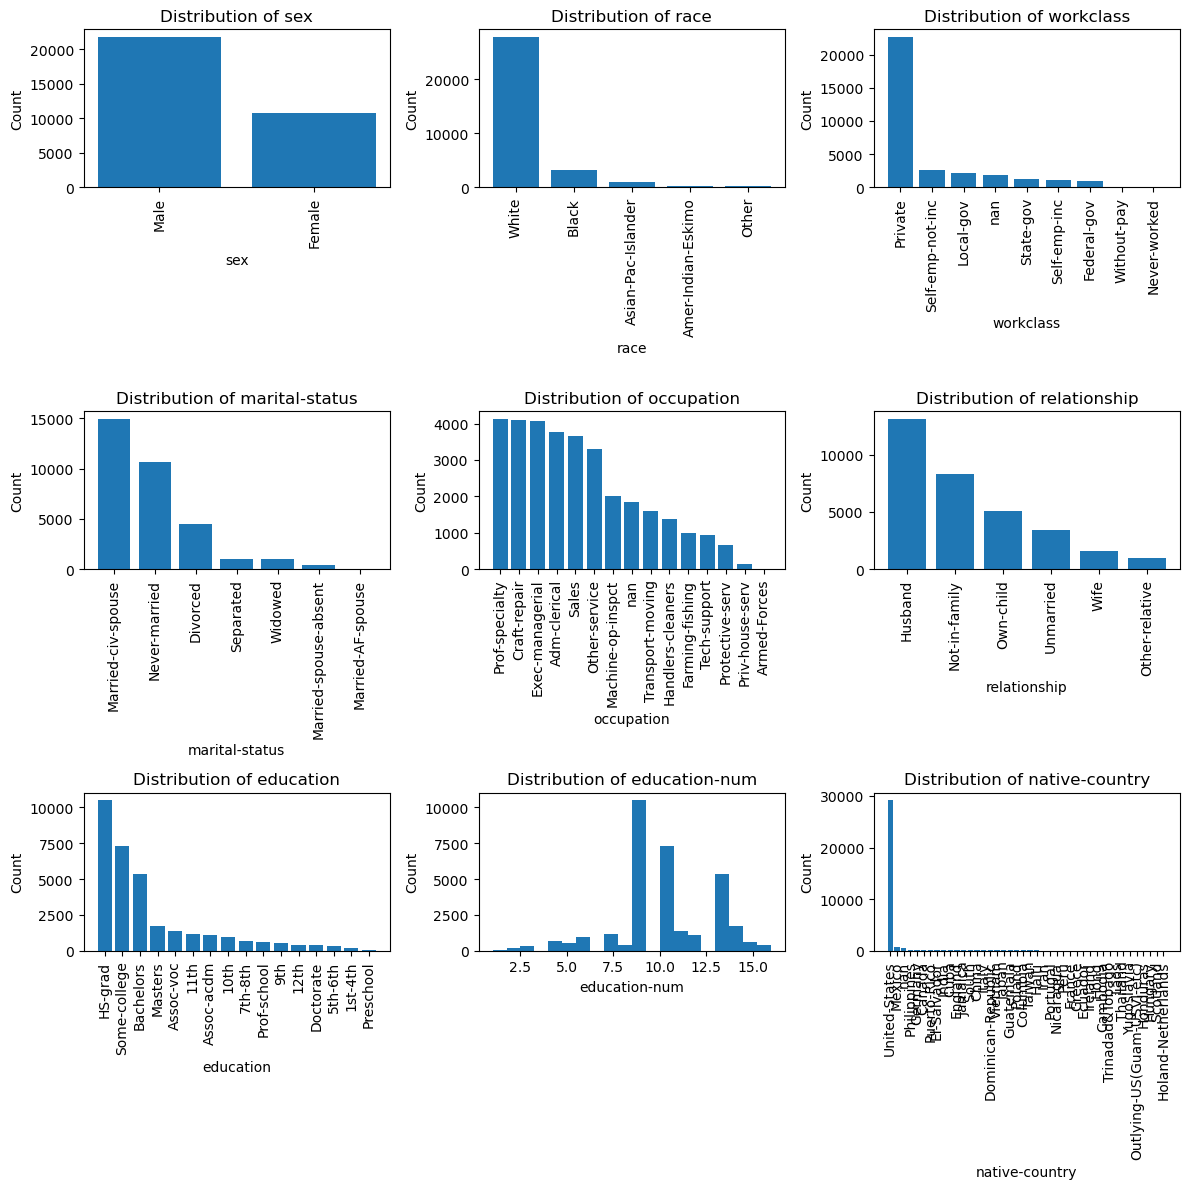

In [51]:
bar_charts = [
    'sex','race','workclass','marital-status','occupation',
    'relationship','education','education-num','native-country'
]

n = len(bar_charts)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
axes = axes.flatten()

for i, column in enumerate(bar_charts):
    s = train_df[column]

    if pd.api.types.is_numeric_dtype(s):
        axes[i].hist(s.dropna(), bins=20)
    else:
        counts = s.value_counts(dropna=False)
        axes[i].bar(range(len(counts)), counts.values)
        axes[i].set_xticks(range(len(counts)))
        axes[i].set_xticklabels(counts.index.astype(str), rotation=90)

    axes[i].set_title(f"Distribution of {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Count")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

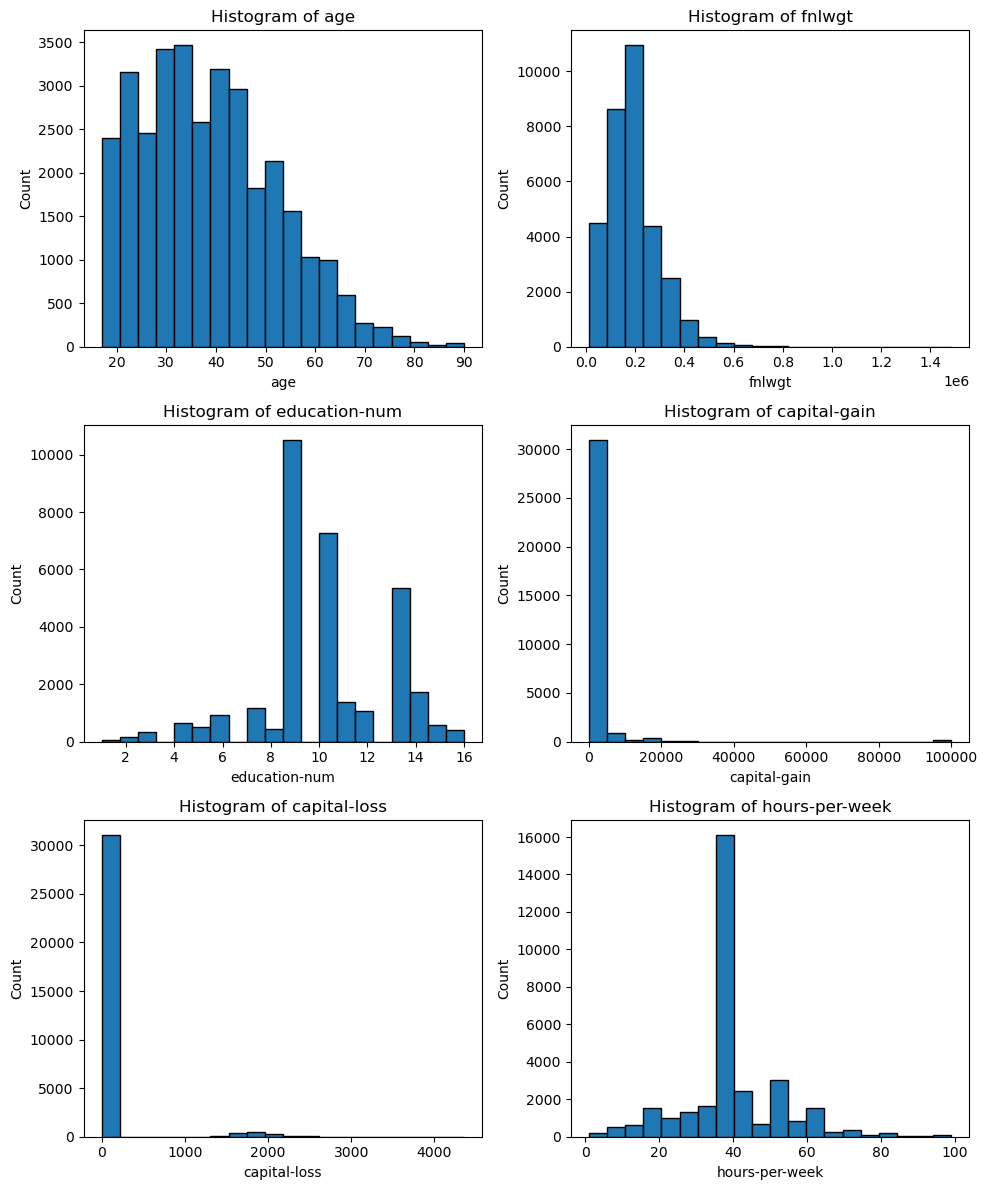

In [52]:
hist_charts = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

cols = 2
rows = 3

fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows))
axes = axes.flatten()   
for i, column in enumerate(hist_charts):
    ax = axes[i]

    # Drop NA values for safety
    data = train_df[column].dropna()

    ax.hist(data, bins=20, edgecolor='black')
    
    ax.set_title(f"Histogram of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Count")

# Remove ANY unused subplot axes entirely
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Recategorize the Categorical features into more meaningful groups

In [53]:
workclass_mapping = {
    'State-gov':'Government',
    'Local-gov':'Government',
    'Federal-gov':'Government',
    'Self-emp-inc':'Entrepreneur',
    'Self-emp-not-inc':'Entrepreneur',
    'Without-pay':'Unemployed',
    'Never-worked':'Unemployed',
    'Private':'Private'
}

# Apply mapping and insert into dataframe
train_df.insert(2,'workclass-cat',train_df['workclass'].map(workclass_mapping))

edu_mapping = {
    'Preschool':'HS-dropout',
    '1st-4th':'HS-dropout',
    '5th-6th':'HS-dropout',
    '7th-8th':'HS-dropout',
    '9th':'HS-dropout',
    '10th':'HS-dropout',
    '11th':'HS-dropout',
    '12th':'HS-dropout',
    'HS-grad':'HS-grad',
    'Some-college':'Some-college',
    'Assoc-acdm':'Some-college',
    'Assoc-voc':'Some-college',
    'Bachelors':'Bachelors',
    'Masters':'Advanced-degree',
    'Prof-school':'Advanced-degree',
    'Doctorate':'Advanced-degree'
}

train_df.insert(4,"education-cat",train_df['education'].map(edu_mapping))

marital_mapping = {
    'Never-married':'Single/Unmarried',
    'Divorced':'Single/Unmarried',
    'Separated':'Single/Unmarried',
    'Widowed':'Single/Unmarried',
    'Married-spouse-absent':'Single/Unmarried',
    'Married-civ-spouse':'Married',
    'Married-AF-spouse':'Married'
}

train_df.insert(7,'marital-cat',train_df['marital-status'].map(marital_mapping))

occupation_mapping = {
    'Exec-managerial':'White-collar',
    'Prof-specialty':'White-collar',
    'Tech-support':'White-collar',
    
    'Other-service':'Service',
    'Sales':'Service',
    'Adm-clerical':'Service',
    'Protective-serv':'Service',
    
    'Craft-repair':'Blue-collar',
    'Transport-moving':'Blue-collar',
    'Machine-op-inspct':'Blue-collar',

    'Armed-Forces':'Military',

    'Priv-house-serv':'Manual',
    'Farming-fishing':'Manual',
    'Handlers-cleaners':'Manual'
}

train_df.insert(10,'occupation-cat',train_df['occupation'].map(occupation_mapping))

s = train_df['native-country']

native_imm_cat = (
    s.map({'United-States': 'Native'})         # US → Native, others → NaN
     .fillna('Immigrant')                     # non-US, non-missing → Immigrant
     .where(s.notna(), pd.NA)                 # where original was missing, keep NA
)

native_imm_cat.replace({pd.NA:np.nan}, inplace = True)

train_df.insert(18, 'native_imm_cat', native_imm_cat)


# drop all adjusted categorical features in favor of their derived categories
train_df.drop(['workclass','fnlwgt','education','education-num','marital-status','occupation','native-country'], axis = 1, inplace = True)

## Missing Values

In [77]:
train_df.isna().sum()

age                  0
workclass-cat     1836
education-cat        0
marital-cat          0
occupation-cat    1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native_imm_cat     582
pred                 0
dtype: int64

In [80]:
#Columns that have missing values
columns = {'workclass-cat', 'occupation-cat', 'native_imm_cat'}

In [81]:
#Print only the columns that contain NA values
for col in columns:
    if train_df[col].isna().any():
        print(f"\n{col}")
        print(train_df[col].unique())


workclass-cat
['Government' 'Entrepreneur' 'Private' nan 'Unemployed']

occupation-cat
['Service' 'White-collar' 'Manual' 'Blue-collar' nan 'Military']

native_imm_cat
['Native' 'Immigrant' nan]


In [82]:
#Delete Rows with Missing Values (NA) -1 
df_deleted=train_df.dropna()

In [83]:
#Unique values after deleting missing values
for col in columns:     
    print(f"\n {col}")
    print(df_deleted[col].unique())


 workclass-cat
['Government' 'Entrepreneur' 'Private' 'Unemployed']

 occupation-cat
['Service' 'White-collar' 'Manual' 'Blue-collar' 'Military']

 native_imm_cat
['Native' 'Immigrant']


In [84]:
print(len(train_df))
print(len(df_deleted))
print(len(train_df)-len(df_deleted)) #Number of deleted rows

32537
30139
2398


In [85]:
#Imputation: mode - 2
df_mode = train_df.copy()

for col in columns:
    df_mode[col] = df_mode[col].fillna(df_mode[col].mode()[0])

In [86]:
#Imputation: New category ("Unknown") - 3
df_unknown = train_df.copy()

for col in columns:
    df_unknown[col] = df_unknown[col].fillna("Unknown")

In [87]:
#Imputation: Random sampling -3 
df_random = train_df.copy()

for col in columns:
    missing_idx = df_random[col].isna()
    n_missing = missing_idx.sum()
    
    if n_missing > 0:
        sampled_values = df_random[col].dropna().sample(
            n_missing, replace=True, random_state=42
        ).values
        
        df_random.loc[missing_idx, col] = sampled_values

In [89]:
#Imputation: Predictive Modeling 4 - (1)
#Replace missing values in the input features with a new category called "Unknown".

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


df_imputed = train_df.copy()
df_imputed = df_imputed.replace({pd.NA: np.nan})

for target_col in columns:
    
    train_df2 = df_imputed[df_imputed[target_col].notna()]
    test_df2  = df_imputed[df_imputed[target_col].isna()]

    X = train_df2.drop(columns=[target_col])
    y = train_df2[target_col]


    X_train_eval, X_val, y_train_eval, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    X_test = test_df2.drop(columns=[target_col])

    cat_cols = X.select_dtypes(include='object').columns
    num_cols = X.select_dtypes(exclude='object').columns

    preprocess = ColumnTransformer([
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
            ("encoder", OneHotEncoder(handle_unknown='ignore'))
        ]), cat_cols),
        ("num", SimpleImputer(strategy="median"), num_cols)
    ])
    
    model = Pipeline([
        ("preprocess", preprocess),
        ("clf", RandomForestClassifier())
    ])

    model.fit(X_train_eval, y_train_eval)

    val_preds = model.predict(X_val)
    acc = accuracy_score(y_val, val_preds)
    print(f"[{target_col}] Accuracy: {acc:.4f}")

    model.fit(X, y)

    preds = model.predict(X_test)
    df_imputed.loc[df_imputed[target_col].isna(), target_col] = preds


[workclass-cat] Accuracy: 0.6957
[occupation-cat] Accuracy: 0.5108
[native_imm_cat] Accuracy: 0.9099


In [90]:
#Imputation: Predictive Modeling 4 - (2) 
#Replace missing values in the input features with the most frequent category (mode).

df_imputed = train_df.copy()
df_imputed = df_imputed.replace({pd.NA: np.nan})

for target_col in columns:
    
    train_df2 = df_imputed[df_imputed[target_col].notna()]
    test_df2  = df_imputed[df_imputed[target_col].isna()]

    X = train_df2.drop(columns=[target_col])
    y = train_df2[target_col]


    X_train_eval, X_val, y_train_eval, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    X_test = test_df2.drop(columns=[target_col])

    #Separate categorical and numerical columns
    cat_cols = X.select_dtypes(include='object').columns
    num_cols = X.select_dtypes(exclude='object').columns

    preprocess = ColumnTransformer([
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols),

    ("num", "passthrough", num_cols)
    ])

    
    model = Pipeline([
        ("preprocess", preprocess),
        ("clf", RandomForestClassifier())
    ])

    model.fit(X_train_eval, y_train_eval)

    val_preds = model.predict(X_val)
    acc = accuracy_score(y_val, val_preds)
    print(f"[{target_col}] Accuracy: {acc:.4f}")

    model.fit(X, y)

    preds = model.predict(X_test)
    df_imputed.loc[df_imputed[target_col].isna(), target_col] = preds


[workclass-cat] Accuracy: 0.6919
[occupation-cat] Accuracy: 0.5152
[native_imm_cat] Accuracy: 0.9100


There are many ways like row deletion and random sampling.  
but I used the two most common approaches: introducing a new category and imputing with the mode.

## One Hot Encoding and Correlation Matrix

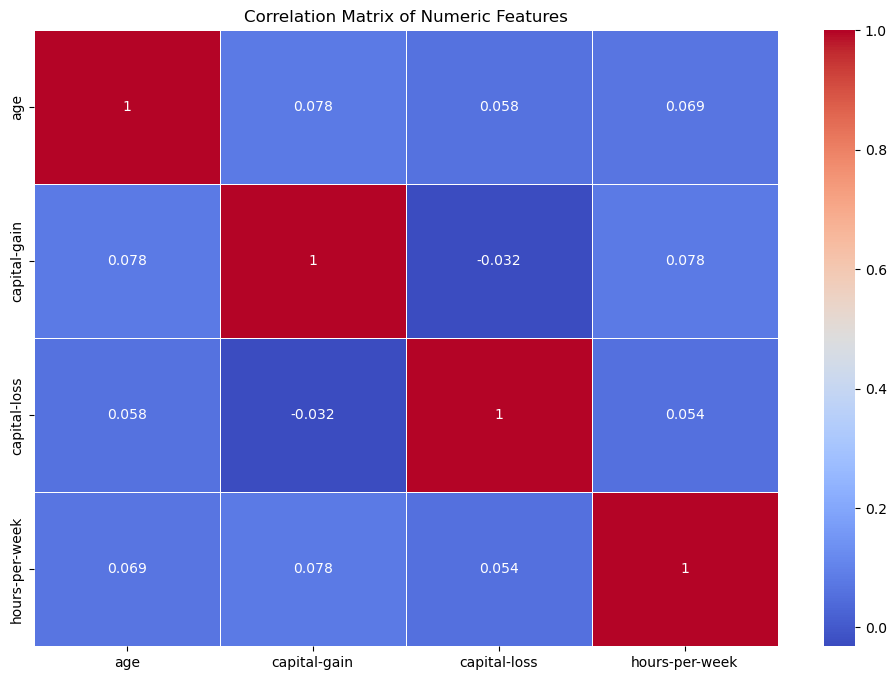

In [54]:
#OHE for numerical features only

# Select numeric columns only
numeric_df = train_df.select_dtypes(include=['int32', 'int64', 'float64'])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

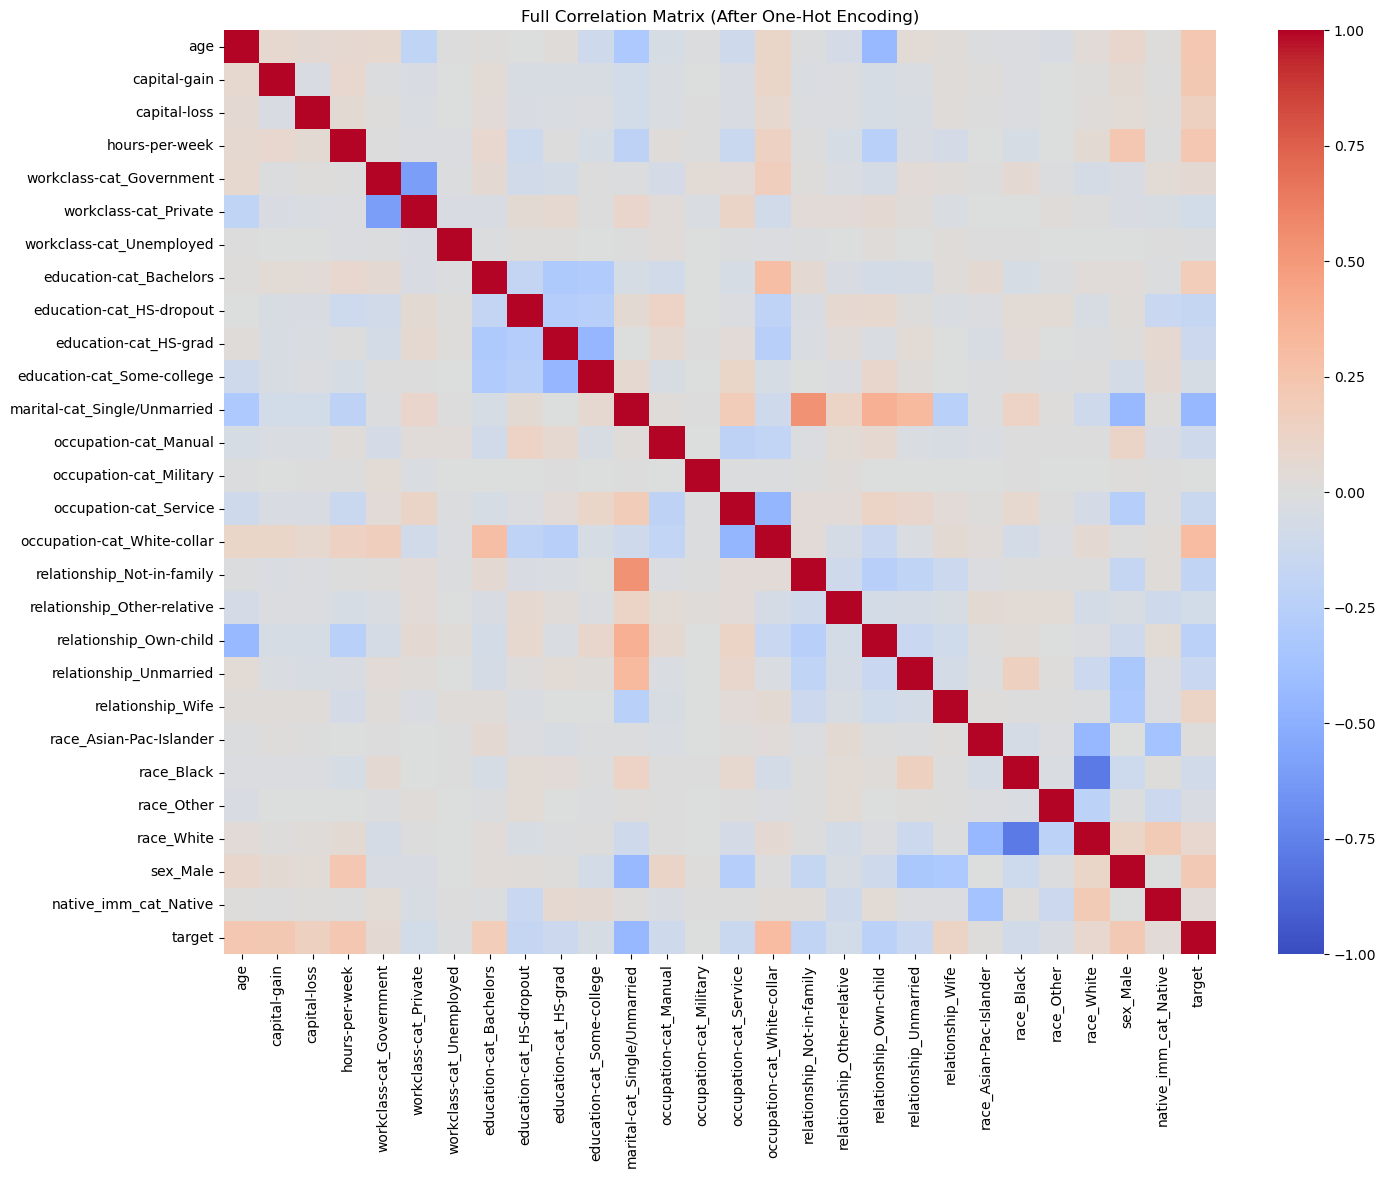

In [55]:
#OHE for correlation matrix

# One-hot encode categorical features
encoded_df = pd.get_dummies(train_df.drop(columns=['pred']), drop_first=True)

# Add encoded label for correlation study
encoded_df['target'] = train_df['pred'].apply(lambda x: 1 if x == '>50K' else 0)

corr = encoded_df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Full Correlation Matrix (After One-Hot Encoding)")
plt.show()

In [56]:
# Convert to pairs of correlations
corr_pairs = corr.unstack()

# Sort by absolute value, descending
corr_pairs_sorted = corr_pairs.abs().sort_values(ascending=False)
corr_pairs_sorted = corr_pairs_sorted[corr_pairs_sorted < 0.999]  

corr_pairs_sorted

race_White                   race_Black                      0.788741
race_Black                   race_White                      0.788741
workclass-cat_Private        workclass-cat_Government        0.595670
workclass-cat_Government     workclass-cat_Private           0.595670
relationship_Not-in-family   marital-cat_Single/Unmarried    0.538223
                                                               ...   
workclass-cat_Unemployed     age                             0.000240
sex_Male                     workclass-cat_Unemployed        0.000139
workclass-cat_Unemployed     sex_Male                        0.000139
sex_Male                     occupation-cat_White-collar     0.000028
occupation-cat_White-collar  sex_Male                        0.000028
Length: 756, dtype: float64

In [57]:
# Convert pred to binary
binary_corr_df = train_df.copy()

binary_corr_df['target'] = binary_corr_df['pred'].apply(lambda x: 1 if x == '>50K' else 0)

# One-hot encode ALL features except target
encoded = pd.get_dummies(binary_corr_df.drop(columns=['pred']), drop_first=True)

# Compute correlation with target only
corr_target = encoded.corr()['target'].sort_values(ascending=False)

corr_target

target                          1.000000
occupation-cat_White-collar     0.305514
age                             0.234037
hours-per-week                  0.229658
capital-gain                    0.223336
sex_Male                        0.215969
education-cat_Bachelors         0.180535
capital-loss                    0.150501
relationship_Wife               0.123230
race_White                      0.085235
workclass-cat_Government        0.061812
native_imm_cat_Native           0.034206
race_Asian-Pac-Islander         0.010600
occupation-cat_Military        -0.005049
workclass-cat_Unemployed       -0.014317
race_Other                     -0.031861
education-cat_Some-college     -0.052184
workclass-cat_Private          -0.078418
relationship_Other-relative    -0.083782
race_Black                     -0.089107
occupation-cat_Manual          -0.108385
education-cat_HS-grad          -0.131343
occupation-cat_Service         -0.135456
relationship_Unmarried         -0.142948
education-cat_HS

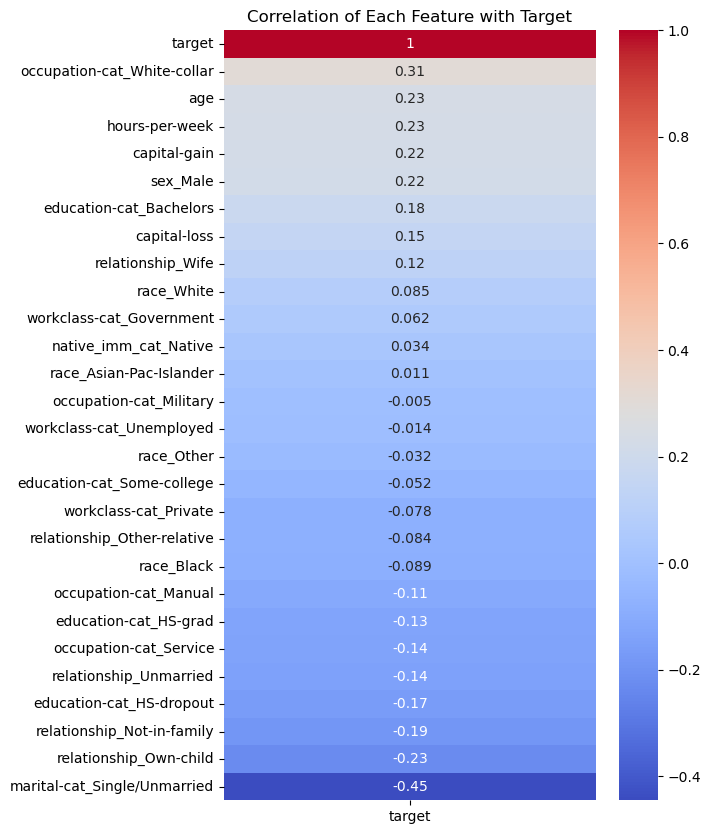

In [58]:
plt.figure(figsize=(6,10))
sns.heatmap(corr_target.to_frame(), annot=True, cmap='coolwarm')
plt.title("Correlation of Each Feature with Target")
plt.show()

In [59]:
# Remove native-country
encoded_filtered = encoded.drop(columns=[col for col in encoded.columns 
                                         if col.startswith("native-country_")])

# Remove numeric columns
numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain',
                'capital-loss', 'hours-per-week', 'target']  
encoded_filtered = encoded_filtered.drop(columns=[col for col in numeric_cols 
                                                  if col in encoded_filtered.columns])

# Compute correlation with target only (SORTED DESCENDING)
corr_target_only = encoded_filtered.join(binary_corr_df['target']) \
                                   .corr()['target'] \
                                   .sort_values(ascending=False)


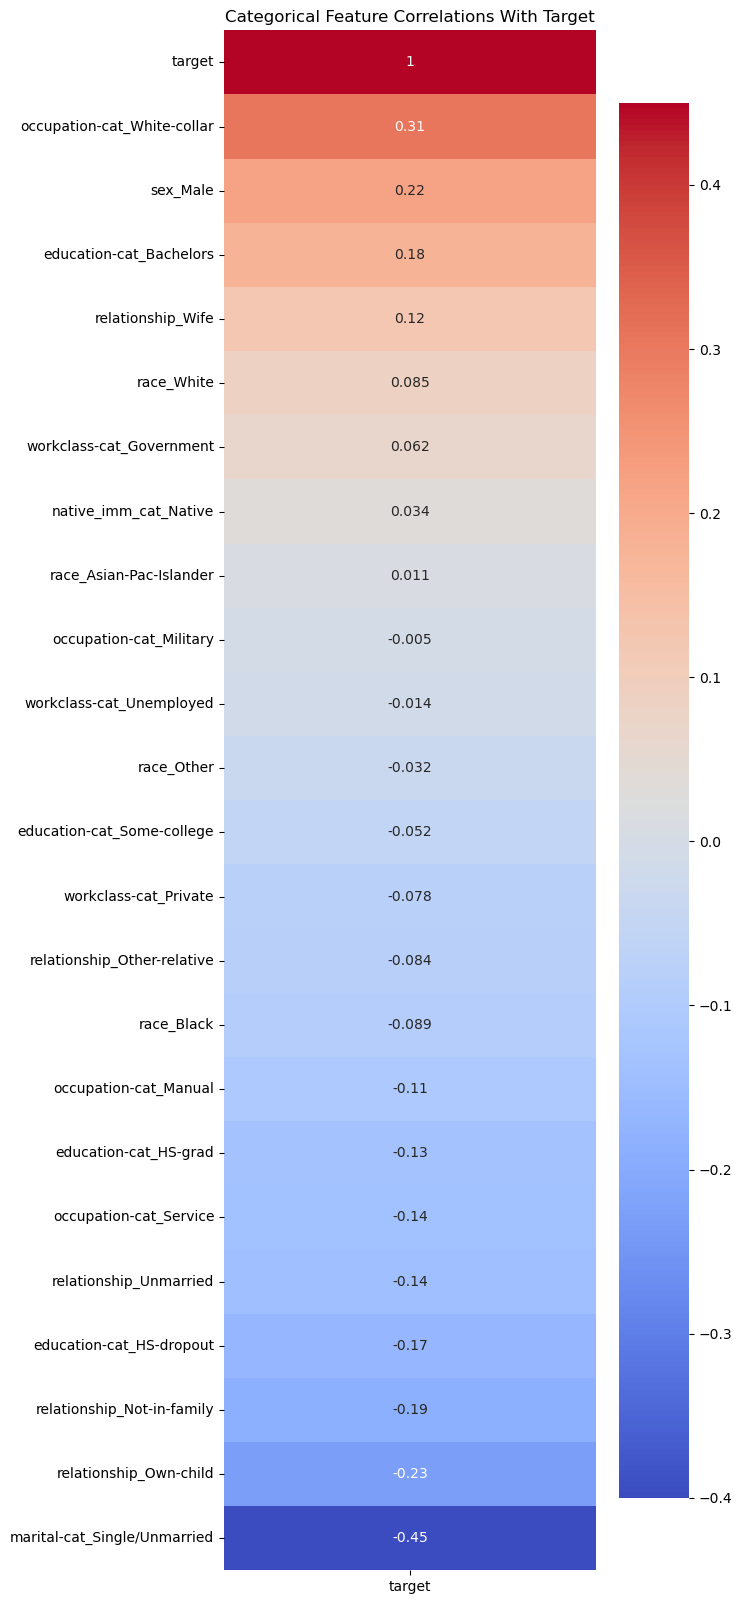

In [60]:
plt.figure(figsize=(6, 20))
sns.heatmap(corr_target_only.to_frame(),
            annot=True,
            cmap='coolwarm',
            vmin=-0.4,
            vmax=0.45)
plt.title("Categorical Feature Correlations With Target")
plt.show()

In [61]:
# Full correlation matrix among remaining categorical columns
cat_corr_matrix = encoded_filtered.corr()

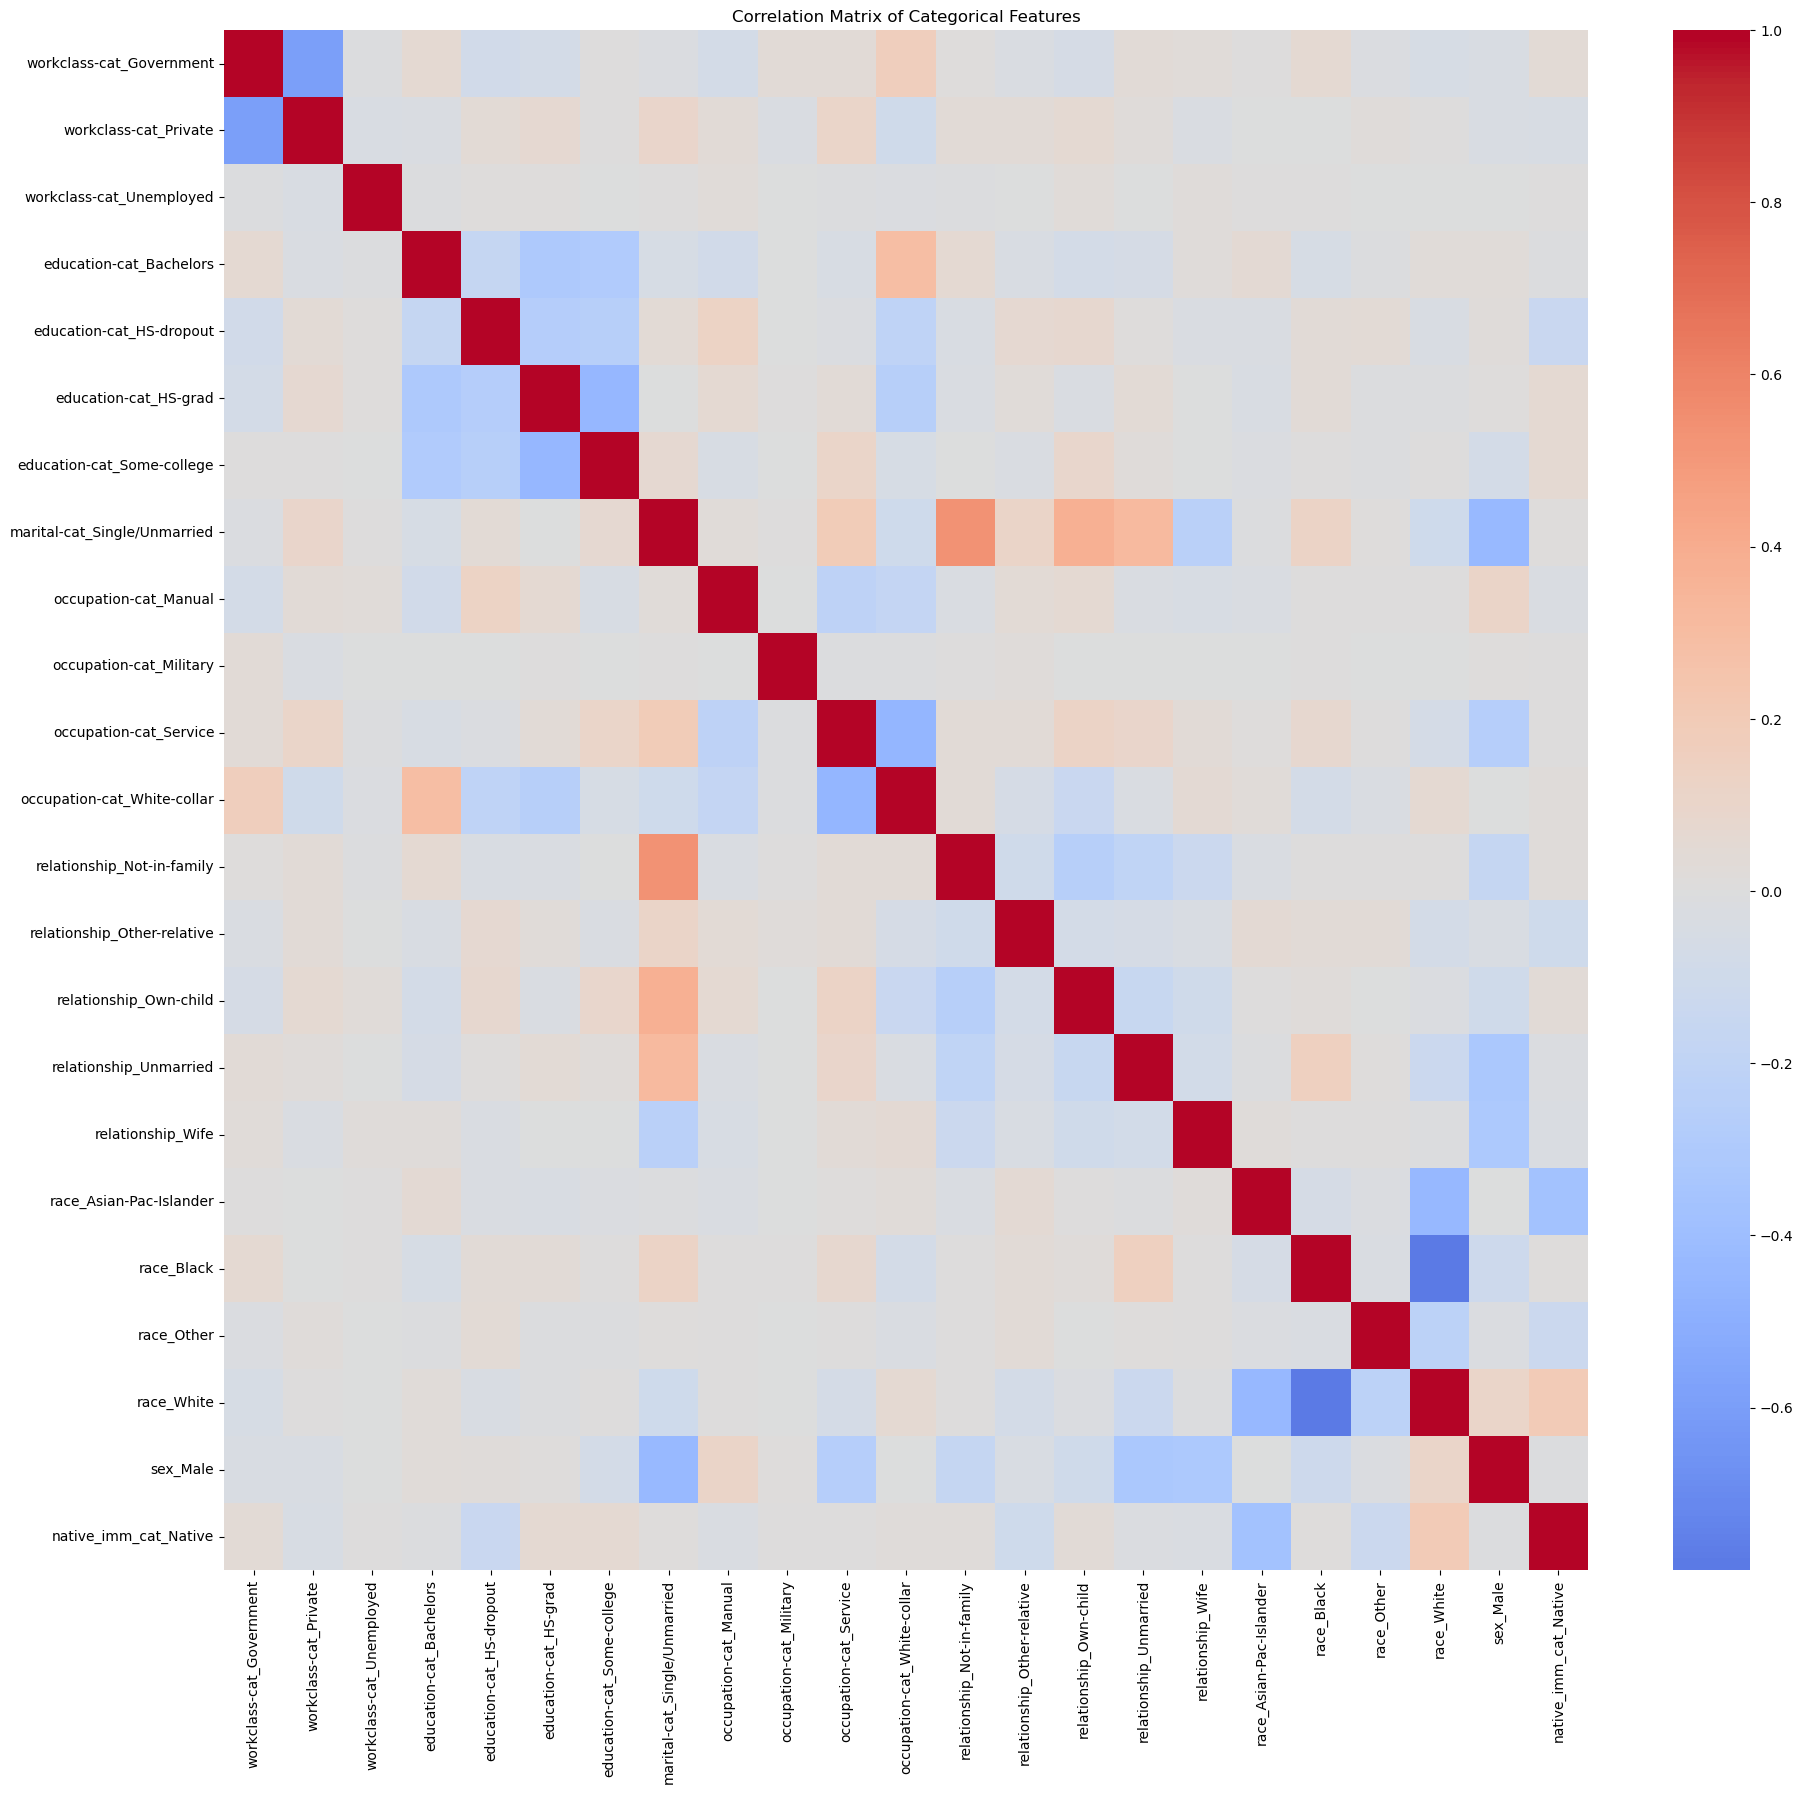

In [62]:
plt.figure(figsize=(22, 20))
sns.heatmap(cat_corr_matrix, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Categorical Features")
plt.show()

## Normalization --- Jieun's Part

capital-gain and capital-loss variables are extremely right-skewed with heavy zeros and a few large outliers. Standard normalization (like Min–Max or Z-score) will not work well.

In [63]:
#Log transformation (best for heavy right-skew)
log_train_df = train_df.copy()

log_train_df['capital_gain_log'] = np.log1p(log_train_df['capital-gain'])
log_train_df['capital_loss_log'] = np.log1p(log_train_df['capital-loss'])

#log1p(x) handles zeros safely.
#Compresses extreme values.
#Spreads out dense low-value regions.

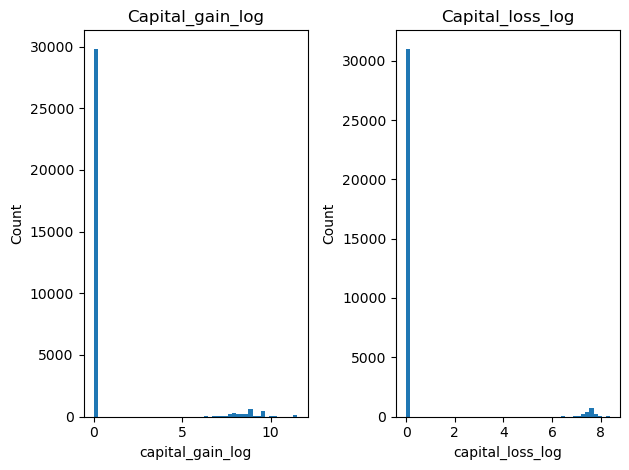

In [64]:
#capital gain
plt.subplot(1, 2, 1)
plt.hist(log_train_df['capital_gain_log'], bins=50)
plt.title("Capital_gain_log")
plt.xlabel("capital_gain_log")
plt.ylabel("Count")

#capital loss
plt.subplot(1, 2, 2)
plt.hist(log_train_df['capital_loss_log'], bins=50)
plt.title("Capital_loss_log")
plt.xlabel("capital_loss_log")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [65]:
log_train_df

,age,workclass-cat,education-cat,marital-cat,occupation-cat,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native_imm_cat,pred,capital_gain_log,capital_loss_log
0,39,Government,Bachelors,Single/Unmarried,Service,Not-in-family,White,Male,2174,0,40,Native,<=50K,7.684784,0.0
1,50,Entrepreneur,Bachelors,Married,White-collar,Husband,White,Male,0,0,13,Native,<=50K,0.000000,0.0
2,38,Private,HS-grad,Single/Unmarried,Manual,Not-in-family,White,Male,0,0,40,Native,<=50K,0.000000,0.0
3,53,Private,HS-dropout,Married,Manual,Husband,Black,Male,0,0,40,Native,<=50K,0.000000,0.0
4,28,Private,Bachelors,Married,White-collar,Wife,Black,Female,0,0,40,Immigrant,<=50K,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Some-college,Married,White-collar,Wife,White,Female,0,0,38,Native,<=50K,0.000000,0.0
32557,40,Private,HS-grad,Married,Blue-collar,Husband,White,Male,0,0,40,Native,>50K,0.000000,0.0
32558,58,Private,HS-grad,Single/Unmarried,Service,Unmarried,White,Female,0,0,40,Native,<=50K,0.000000,0.0
32559,22,Private,HS-grad,Single/Unmarried,Service,Own-child,White,Male,0,0,20,Native,<=50K,0.000000,0.0


In [66]:
#Binning
bin_train_df = train_df.copy()

# capital-gain bins
gain_bins = [-1, 0, 5000, 15000, 30000, np.inf]
gain_labels = ['no_gain', 'low_gain', 'medium_gain', 'high_gain', 'very_high_gain']

bin_train_df['capital_gain_bin'] = pd.cut(
    bin_train_df['capital-gain'], 
    bins=gain_bins, 
    labels=gain_labels
)

# capital-loss bins
loss_bins = [-1, 0, 1000, 2000, np.inf]
loss_labels = ['no_loss', 'low_loss', 'medium_loss', 'high_loss']

bin_train_df['capital_loss_bin'] = pd.cut(
    bin_train_df['capital-loss'],
    bins=loss_bins,
    labels=loss_labels
)

bin_train_df.drop(['capital-gain','capital-loss'],axis=1, inplace=True)

print(bin_train_df['capital_gain_bin'].value_counts(), "\n\n")
print(bin_train_df['capital_loss_bin'].value_counts())

capital_gain_bin
no_gain           29825
low_gain           1064
medium_gain        1035
high_gain           447
very_high_gain      166
Name: count, dtype: int64 


capital_loss_bin
no_loss        31018
medium_loss     1158
high_loss        325
low_loss          36
Name: count, dtype: int64


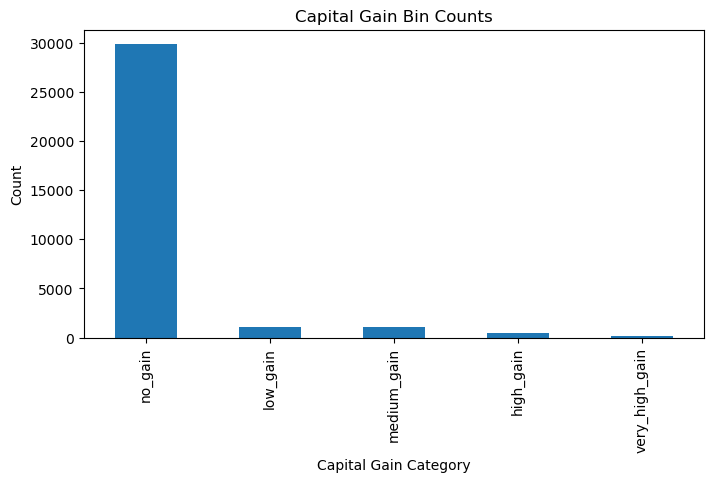

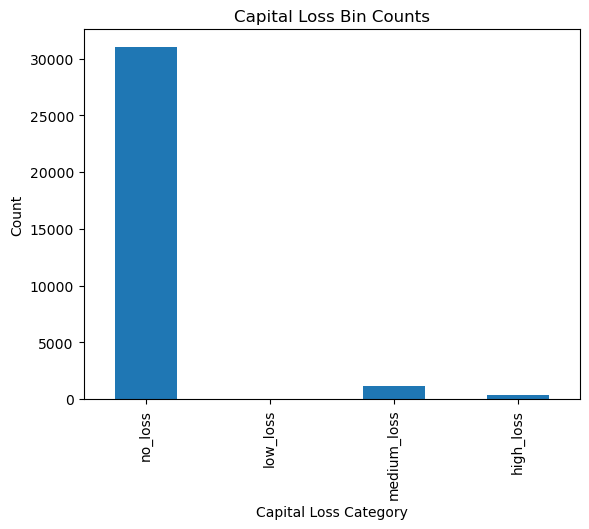

In [67]:
plt.figure(figsize=(8, 4))
bin_train_df['capital_gain_bin'].value_counts().sort_index().plot(kind='bar')
plt.title("Capital Gain Bin Counts")
plt.xlabel("Capital Gain Category")
plt.ylabel("Count")
plt.show()

bin_train_df['capital_loss_bin'].value_counts().sort_index().plot(kind='bar')
plt.title("Capital Loss Bin Counts")
plt.xlabel("Capital Loss Category")
plt.ylabel("Count")
plt.show()

In [68]:
bin_train_df

,age,workclass-cat,education-cat,marital-cat,occupation-cat,relationship,race,sex,hours-per-week,native_imm_cat,pred,capital_gain_bin,capital_loss_bin
0,39,Government,Bachelors,Single/Unmarried,Service,Not-in-family,White,Male,40,Native,<=50K,low_gain,no_loss
1,50,Entrepreneur,Bachelors,Married,White-collar,Husband,White,Male,13,Native,<=50K,no_gain,no_loss
2,38,Private,HS-grad,Single/Unmarried,Manual,Not-in-family,White,Male,40,Native,<=50K,no_gain,no_loss
3,53,Private,HS-dropout,Married,Manual,Husband,Black,Male,40,Native,<=50K,no_gain,no_loss
4,28,Private,Bachelors,Married,White-collar,Wife,Black,Female,40,Immigrant,<=50K,no_gain,no_loss
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Some-college,Married,White-collar,Wife,White,Female,38,Native,<=50K,no_gain,no_loss
32557,40,Private,HS-grad,Married,Blue-collar,Husband,White,Male,40,Native,>50K,no_gain,no_loss
32558,58,Private,HS-grad,Single/Unmarried,Service,Unmarried,White,Female,40,Native,<=50K,no_gain,no_loss
32559,22,Private,HS-grad,Single/Unmarried,Service,Own-child,White,Male,20,Native,<=50K,no_gain,no_loss


In [69]:
#Binary Indicators
binary_train_df = train_df.copy()

binary_train_df['has_capital_gain'] = (binary_train_df['capital-gain'] > 0).astype(int)
binary_train_df['has_capital_loss'] = (binary_train_df['capital-loss'] > 0).astype(int)

binary_train_df.drop(['capital-gain','capital-loss'], axis = 1, inplace = True)

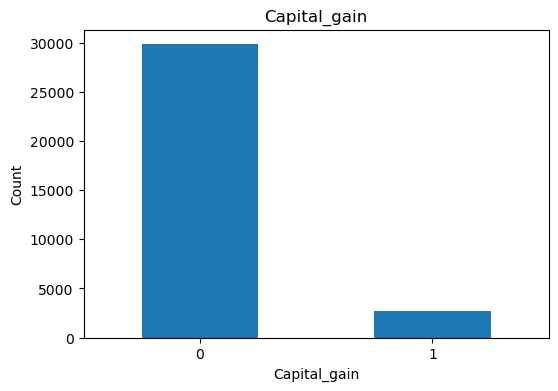

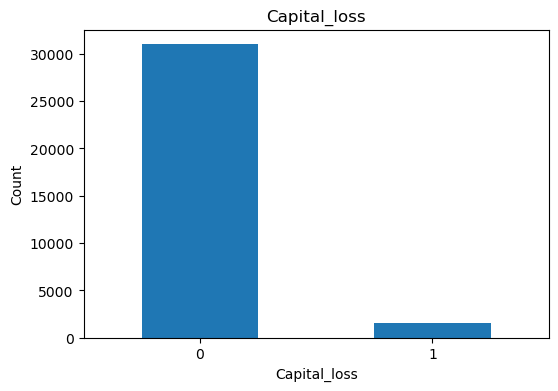

In [70]:
binary_train_df['has_capital_gain'].value_counts().sort_index().plot(
    kind='bar',
    figsize=(6,4),
    rot=0
)
plt.title('Capital_gain')
plt.xlabel('Capital_gain')
plt.ylabel('Count')
plt.show()

binary_train_df['has_capital_loss'].value_counts().sort_index().plot(
    kind='bar',
    figsize=(6,4),
    rot=0
)
plt.title('Capital_loss')
plt.xlabel('Capital_loss')
plt.ylabel('Count')
plt.show()

In [71]:
binary_train_df

,age,workclass-cat,education-cat,marital-cat,occupation-cat,relationship,race,sex,hours-per-week,native_imm_cat,pred,has_capital_gain,has_capital_loss
0,39,Government,Bachelors,Single/Unmarried,Service,Not-in-family,White,Male,40,Native,<=50K,1,0
1,50,Entrepreneur,Bachelors,Married,White-collar,Husband,White,Male,13,Native,<=50K,0,0
2,38,Private,HS-grad,Single/Unmarried,Manual,Not-in-family,White,Male,40,Native,<=50K,0,0
3,53,Private,HS-dropout,Married,Manual,Husband,Black,Male,40,Native,<=50K,0,0
4,28,Private,Bachelors,Married,White-collar,Wife,Black,Female,40,Immigrant,<=50K,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Some-college,Married,White-collar,Wife,White,Female,38,Native,<=50K,0,0
32557,40,Private,HS-grad,Married,Blue-collar,Husband,White,Male,40,Native,>50K,0,0
32558,58,Private,HS-grad,Single/Unmarried,Service,Unmarried,White,Female,40,Native,<=50K,0,0
32559,22,Private,HS-grad,Single/Unmarried,Service,Own-child,White,Male,20,Native,<=50K,0,0


## Shelsy's Part

In [72]:
train_df

,age,workclass-cat,education-cat,marital-cat,occupation-cat,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native_imm_cat,pred
0,39,Government,Bachelors,Single/Unmarried,Service,Not-in-family,White,Male,2174,0,40,Native,<=50K
1,50,Entrepreneur,Bachelors,Married,White-collar,Husband,White,Male,0,0,13,Native,<=50K
2,38,Private,HS-grad,Single/Unmarried,Manual,Not-in-family,White,Male,0,0,40,Native,<=50K
3,53,Private,HS-dropout,Married,Manual,Husband,Black,Male,0,0,40,Native,<=50K
4,28,Private,Bachelors,Married,White-collar,Wife,Black,Female,0,0,40,Immigrant,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Some-college,Married,White-collar,Wife,White,Female,0,0,38,Native,<=50K
32557,40,Private,HS-grad,Married,Blue-collar,Husband,White,Male,0,0,40,Native,>50K
32558,58,Private,HS-grad,Single/Unmarried,Service,Unmarried,White,Female,0,0,40,Native,<=50K
32559,22,Private,HS-grad,Single/Unmarried,Service,Own-child,White,Male,0,0,20,Native,<=50K


In [73]:
#undersampling
X_train = train_df.drop ('pred', axis=1)
Y_train = train_df['pred']

under= RandomUnderSampler(random_state=42)
X_under, Y_under = under.fit_resample(X_train, Y_train)

print ('before:' , Y_train.value_counts())
print ('after:' , Y_under.value_counts())

before: pred
<=50K    24698
>50K      7839
Name: count, dtype: int64
after: pred
<=50K    7839
>50K     7839
Name: count, dtype: int64


In [74]:
#oversampling
over = RandomOverSampler(random_state=42)
X_over, Y_over = over.fit_resample(X_train, Y_train)
print ('before:' , Y_train.value_counts())
print ('after:' , Y_over.value_counts())

before: pred
<=50K    24698
>50K      7839
Name: count, dtype: int64
after: pred
<=50K    24698
>50K     24698
Name: count, dtype: int64


In [75]:
train_df['capital-gain'].describe()

count    32537.000000
mean      1078.443741
std       7387.957424
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital-gain, dtype: float64

In [76]:
train_df.isna().sum()

age                  0
workclass-cat     1836
education-cat        0
marital-cat          0
occupation-cat    1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native_imm_cat     582
pred                 0
dtype: int64